In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from joblib import Parallel, delayed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.layers import Dense, LSTM, Dropout
import warnings
warnings.filterwarnings("ignore")

In [2]:
counties=10
train_data = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv')
test_data = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv')
census_data = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv')
train_data=train_data[:39*counties]
min_date = pd.to_datetime(min(train_data['first_day_of_month']))
max_date = pd.to_datetime(max(train_data['first_day_of_month']))
margin =  ( max_date.to_period('M')  ) \
                                   - ( min_date.to_period('M')  ) 

dict_val = {}
for leng, val in enumerate(train_data.cfips.unique()):
    dict_val[val] = leng
    


scaler = StandardScaler()

#data for broadband access
#census_data.iloc[:,0:5]=scaler.fit_transform(census_data.iloc[:,0:5].to_numpy())

#population percent of 4yr degree
#census_data.iloc[:,6:11]=scaler.fit_transform(census_data.iloc[:,6:11].to_numpy())

#percent of born outside of the US
#census_data.iloc[:,11:16]=scaler.fit_transform(census_data.iloc[:,11:16].to_numpy())

#percent of IT workers
#census_data.iloc[:,16:21]=scaler.fit_transform(census_data.iloc[:,16:21].to_numpy())

#income level
#census_data.iloc[:,21:26]=scaler.fit_transform(census_data.iloc[:,21:26].to_numpy())

first_column = census_data.pop('cfips')
census_data.insert(0, 'cfips', first_column)
census_data.iloc[:,1:26]=scaler.fit_transform(census_data.iloc[:,1:26].to_numpy())


def census_to_train(row,idNum,dataset):
    row=row
    idNum = idNum
    year=pd.to_datetime(train_data['first_day_of_month'][row]).year - 2
    temp_cen_data = pd.DataFrame(census_data[census_data['cfips'] == idNum])
    
    dataset.loc[row,"pct_bb"] = float(temp_cen_data["pct_bb_" + str(year)])
    dataset.loc[row,"pct_college"] = float(temp_cen_data["pct_college_"+ str(year)])
    dataset.loc[row,"pct_foreign_born"] = float(temp_cen_data["pct_foreign_born_"+ str(year)])
    dataset.loc[row,"pct_it_workers"] = float(temp_cen_data["pct_it_workers_"+ str(year)])
    dataset.loc[row,"median_hh_inc"] = float(temp_cen_data["median_hh_inc_"+ str(year)])


def init_to_feature(dataset,LSTM=False,Test=False):
    #dataset['numMons'] = " "
    dates = np.array(dataset['first_day_of_month'])

    #numMons = ( (pd.to_datetime(dates).to_period('M')   ) \
    #                               - ( min_date.to_period('M')  ) )
    #for i in range(len(dataset)):
    #    dataset.loc[i,'numMons'] = numMons[i].n +1
    dataset['numMons'] = " "
    months0=np.arange(1,margin.n+2,1)
    months=[]
    for i in range(len(dict_val)):
        months=np.concatenate((months,months0))
    dataset['numMons'] = months

    
    
    
    dataset["countyID"] = " "
    for leng, val in enumerate(dataset['cfips']):
        dataset.loc[leng,"countyID"] = dict_val[dataset.loc[leng,'cfips']]
       
    dataset = dataset.sort_values(['countyID', 'numMons'],\
              ascending = [True, True])

    #dataset["pct_bb"] = " "
    #dataset["pct_college"] = " "
    #dataset["pct_foreign_born"] = " "
    #dataset["pct_it_workers"] = " "
    #dataset["median_hh_inc"] = " "

    
    
    #for row, idNum in enumerate(tqdm(dataset['cfips'])):
    #     census_to_train(row,idNum,dataset)
   
    
    
    
    if LSTM==True and Test==False:
        new_set=[]
        for i in np.arange(0, len(dataset),39):
            new_set.append(dataset[i:i+30])
        dataset = pd.concat(new_set)
        
    if LSTM==True and Test==True:
        new_set=[]
        for i in np.arange(0, len(dataset),39):
            new_set.append(dataset[i+28:i+39])
        dataset = pd.concat(new_set)
    
    
    #features = np.array(dataset[['countyID','numMons','pct_bb','pct_college',\
    #                           'pct_foreign_born','pct_it_workers','median_hh_inc','microbusiness_density']])

    features = np.array(dataset[['numMons','microbusiness_density']])
    IDs = np.array(dataset['countyID'])
                                 
    return features, IDs


In [3]:
#test_features = init_to_feature(test_data,LSTM=False)

train = init_to_feature(train_data[:],LSTM=True,Test=False)
test = init_to_feature(train_data[:],LSTM=True,Test=True)

train_features = train[0]
test_features = test[0]

trainids = train[1]
testids = test[1]

In [4]:
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()
#train_features = scaler.fit_transform(train_features)
#test_features = scaler.fit_transform(test_features)

In [5]:

train_target = np.array(train_features[:,1])
test_target = np.array(test_features[:,1])

train_features = train_features[:,:]
test_features = test_features[:,:]

train_features= np.c_[ trainids, train_features  ]
test_features= np.c_[ testids, test_features  ]


In [6]:
#counties=200
#train_data = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv')
#test_data = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv')
#census_data = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv')
#train_data=train_data[:39*counties]
#min_date = pd.to_datetime(min(train_data['first_day_of_month']))
#max_date = pd.to_datetime(max(train_data['first_day_of_month']))
#margin =  ( max_date.to_period('M')  ) \
#                                   - ( min_date.to_period('M')  ) 

#dict_val = {}
#for leng, val in enumerate(train_data.cfips.unique()):
#    dict_val[val] = leng
    


#scaler = StandardScaler()

#data for broadband access
#census_data.iloc[:,0:5]=scaler.fit_transform(census_data.iloc[:,0:5].to_numpy())

#population percent of 4yr degree
#census_data.iloc[:,6:11]=scaler.fit_transform(census_data.iloc[:,6:11].to_numpy())

#percent of born outside of the US
#census_data.iloc[:,11:16]=scaler.fit_transform(census_data.iloc[:,11:16].to_numpy())

#percent of IT workers
#census_data.iloc[:,16:21]=scaler.fit_transform(census_data.iloc[:,16:21].to_numpy())

#income level
#census_data.iloc[:,21:26]=scaler.fit_transform(census_data.iloc[:,21:26].to_numpy())


#first_column = census_data.pop('cfips')
#census_data.insert(0, 'cfips', first_column)
#census_data.iloc[:,1:26]=scaler.fit_transform(census_data.iloc[:,1:26].to_numpy())

def census_to_train(row,idNum,dataset):
    row=row
    idNum = idNum
    year=pd.to_datetime(train_data['first_day_of_month'][row]).year - 2
    temp_cen_data = pd.DataFrame(census_data[census_data['cfips'] == idNum])
    
    dataset.loc[row,"pct_bb"] = float(temp_cen_data["pct_bb_" + str(year)])
    dataset.loc[row,"pct_college"] = float(temp_cen_data["pct_college_"+ str(year)])
    dataset.loc[row,"pct_foreign_born"] = float(temp_cen_data["pct_foreign_born_"+ str(year)])
    dataset.loc[row,"pct_it_workers"] = float(temp_cen_data["pct_it_workers_"+ str(year)])
    dataset.loc[row,"median_hh_inc"] = float(temp_cen_data["median_hh_inc_"+ str(year)])


def init_to_feature(dataset,LSTM=False,Test=False):
    #dataset['numMons'] = " "
    dates = np.array(dataset['first_day_of_month'])

    #numMons = ( (pd.to_datetime(dates).to_period('M')   ) \
    #                               - ( min_date.to_period('M')  ) )
    #for i in range(len(dataset)):
    #    dataset.loc[i,'numMons'] = numMons[i].n +1
    dataset['numMons'] = " "
    months0=np.arange(1,(margin.n)+2,1)
    months=[]
    for i in range(len(dict_val)):
        months=np.concatenate((months,months0))
    dataset['numMons'] = months

    
    
    dataset["countyID"] = " "
    for leng, val in enumerate(dataset['cfips']):
        dataset.loc[leng,"countyID"] = dict_val[dataset.loc[leng,'cfips']]
       
    dataset = dataset.sort_values(['countyID', 'numMons'],\
              ascending = [True, True])

    dataset["pct_bb"] = " "
    dataset["pct_college"] = " "
    dataset["pct_foreign_born"] = " "
    dataset["pct_it_workers"] = " "
    dataset["median_hh_inc"] = " "

    
    
    for row, idNum in enumerate(tqdm(dataset['cfips'])):
         census_to_train(row,idNum,dataset)
   
    
    
    
    if LSTM==True and Test==False:
        new_set=[]
        for i in np.arange(0, len(dataset),39):
            new_set.append(dataset[i:i+30])
        dataset = pd.concat(new_set)
        
    if LSTM==True and Test==True:
        new_set=[]
        for i in np.arange(0, len(dataset),39):
            new_set.append(dataset[i+30:i+39])
        dataset = pd.concat(new_set)
    
    
    features = np.array(dataset[['countyID','numMons','pct_bb','pct_college',\
                               'pct_foreign_born','pct_it_workers','median_hh_inc','microbusiness_density']])

    
    return features


#train_features = init_to_feature(train_data[:],LSTM=True,Test=False)
#test_features = init_to_feature(train_data[:],LSTM=True,Test=True)



#train_target = np.array(train_features[:,7])
#test_target = np.array(test_features[:,7])

#train_features = train_features[:,:7]
#test_features = test_features[:,:7]





In [7]:
#def linreg_data(dataset1, dataset2, Train=True):
 #   sep_data1=[]
 #   sep_data2=[]
 #   
 #   if Train==True:
 #       sep_data1.append(dataset1[0:30])
 #       sep_data2.append(dataset2[0:30])
 #       for ids in tqdm(range(1,counties)):
 #           sep_data2.append(dataset2[30*ids:(30*ids)+30])
 #           sep_data1.append(dataset1[30*ids:(30*ids)+30])

 #   if Train==False:
 #       sep_data1.append(dataset1[0:9])
 #       sep_data2.append(dataset2[0:9])
 #       for ids in tqdm(range(1,counties)):
 #           sep_data2.append(dataset2[9*ids:(9*ids)+9])
 #           sep_data1.append(dataset1[9*ids:(9*ids)+9])
    
 #   sep_data2=np.array(sep_data2)
 #   sep_data1=np.array(sep_data1)
    

 #   return sep_data1, sep_data2


#train_lin,traintar_lin=linreg_data(train_features,train_target)
#test_lin,testtar_lin=linreg_data(test_features,test_target, Train=False)

#train_lin = np.delete(train_lin,[0,2,3,4,5,6], axis=2)
#test_lin = np.delete(test_lin,[0,2,3,4,5,6], axis=2)

#train_lin = np.delete(train_lin,[0], axis=2)
#test_lin = np.delete(test_lin,[0], axis=2)

In [8]:

def history_data(dataset1,dataset2, lookback=1):
    data_look=[]
    data_tar=[]
    for i in range(len(dataset1)-lookback):
        val1 = dataset1[i:(i+lookback),:] 
        val2 = dataset2[i+lookback] 
        data_look.append(val1)
        data_tar.append(val2)
    return np.array(data_look), np.array(data_tar)

In [9]:
def lookback_data(ids,featureset,targetset):
   
    dataset1 = featureset[featureset[:,0]==ids]
    dataset2 = targetset[featureset[:,0]==ids]
    rnnset, tar_rnn = history_data(dataset1,dataset2,2)

    rnnset = np.delete(rnnset,[0,1], axis=2)
    #rnnset = np.delete(rnnset,[0,2,3,4,5,6], axis=2)
    rnnset = np.reshape(rnnset, (rnnset.shape[0],rnnset.shape[1],1   ))
    rnnset = rnnset.astype(float)
    
    return rnnset, tar_rnn

In [10]:
from tensorflow import keras
predictions=list(np.zeros(counties))
trues=list(np.zeros(counties))

predictionsList=[]
def lstm_model(ids):
    
    
    
    model = Sequential()
    model.add(LSTM(units=200,input_shape=(2,1)))
    model.add(Dense(1))
    model.compile(optimizer=keras.optimizers.Adam(0.001), loss='mean_squared_error')

    train_rnn, traintar_rnn = lookback_data(ids,train_features,train_target )
    model.fit(train_rnn,traintar_rnn,epochs=300,batch_size=32,verbose=0)
   
    
    preds=[]
    truss =[]
    for i in range(9):
        test_rnn, testtar_rnn = lookback_data(ids,test_features,test_target )
        preds.append(model.predict(test_rnn[i:i+1]))
        truss.append(testtar_rnn[i])
        test_features[:,2][i+2] = model.predict(test_rnn[i:i+1])
    preds=np.array(preds)
    preds=np.reshape(preds,len(preds))
    predictions[ids]= preds
    trues[ids]=truss


In [11]:

#predictions=list(np.zeros(counties))
#trues=list(np.zeros(counties))
#from sklearn.linear_model import LinearRegression
#from sklearn.preprocessing import PolynomialFeatures
#import xgboost as xg

#def linreg_model(ids):
#    poly = PolynomialFeatures(degree = 1)

#    train_linpoly = poly.fit_transform(train_lin[ids])
#    test_linpoly = poly.fit_transform(test_lin[ids])
    
    #reg = LinearRegression()
    
#    reg = xg.XGBRegressor()
#    reg.fit(train_linpoly,traintar_lin[ids])
#    
#    predictions[ids] = reg.predict(test_linpoly)
#    trues[ids] = testtar_lin[ids]
    


In [12]:
for ids in tqdm(range(0,counties)):
    lstm_model(ids)
    #linreg_model(ids)
    

  0%|          | 0/10 [00:00<?, ?it/s]2023-01-28 15:32:11.712893: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-01-28 15:32:12.263769: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
100%|██████████| 10/10 [01:05<00:00,  6.58s/it]


In [13]:
counter=0
summ=0
for tr1,pred1 in zip(trues,predictions):
    for tr2, pred2 in zip(tr1,pred1):
        summ+= abs((-tr2+pred2)/((abs(tr2)+abs(pred2))/2) )
        counter+=1
print('SMAPE: ', summ*100/counter)

SMAPE:  2.7288401387787027


In [14]:
print(trues[3],predictions[3])

[1.2366498, 1.2647555, 1.2535132, 1.247892, 1.2759978, 1.3265879, 1.2928611, 1.3153456, 1.28724] [1.2177308 1.2255595 1.2445664 1.2578659 1.2502546 1.2534451 1.2807639
 1.3017347 1.2877493]


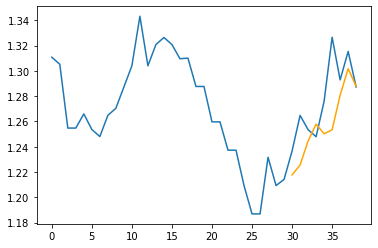

In [15]:
idNum = 3


predictions= np.array(predictions)
predictionsTrans = predictions.reshape(len(predictions),9)


trueVals = np.concatenate((np.array(train_target[idNum*30:(idNum+1)*30]), np.array(trues[idNum])))
predVals = np.concatenate((np.array(train_target[idNum*30:(idNum+1)*30]), np.array(predictionsTrans[idNum])))




plt.plot(range(39),trueVals)
plt.plot(np.arange(30,39,1),predictionsTrans[idNum],color='orange')